In [1]:
import numpy as np
from torchvision.datasets import CocoDetection
import datetime
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import sys 
sys.path.append("/home/tyfei/cyroem")
import utils
import importlib 
importlib.reload(utils)
import pycocotools.coco
import pycocotools.mask

/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
a = [1,2,3,4,5]
list(filter(lambda x: x%2==0, a))

[2, 4]

In [7]:
a = np.array([[0,0,1,1,0],[1,1,0,0,0],[0,1,0,1,0]])
utils.rleUncompressed(a)

[2, 2, 1, 2, 4, 1, 1, 1]

In [2]:
# build images 
data = utils.readTomogram("/data/test_data_ribo/TS_031.mrc_10.30Apx.mrc")
l, h, w = data.shape

In [7]:
import torch
a = torch.randn(2,3,4)
for i in range(2):
    a[i] -= a[i].mean() 
    a[i] /= a[i].std() 
a[1].mean()

tensor(0.)

In [8]:
for i in range(0, 500, 10):
    # images.append(np.array(data[i]))
    res = np.zeros((3, h, w))
    res[1] = data[i] 
    res[0] = np.mean(data[max(0, i-10):max(i, 1)], axis=0)
    res[2] = np.mean(data[i:i+10], axis=0)
    for j in range(3):
        res[j] -= np.min(res[j])
        res[j] /= np.max(res[j])
    # res -= np.min(res) 
    # res /= np.max(res)
    np.save("/home/feity/cryoem/dataset/Mean10_channel/%s_%i.npy"%("TS_031", i), res)

In [21]:
images = [] 
for i in range(0, 400, 10):
    img_name = "%s_%i.npy"%("TS_031", i)
    img_info = {
        "id": len(images) + 1, 
        "license":1, 
        "file_name":img_name, 
        "height":h, 
        "width":w, 
        "date_captured":str(datetime.datetime.now())
    }
    images.append(img_info)

In [22]:
#build annotations 
categories = [
    {"id": 1, "name": "memb"},
    {"id": 2, "name": "nucleus_memb"},
    {"id": 3, "name": "ribo"},
    {"id": 4, "name": "microtubule"},
    {"id": 5, "name": "actin"},
    {"id": 6, "name": "intermediate_filament"},
    {"id": 7, "name": "nucleus"},
    {"id": 8, "name": "nuclear_pore"},
    {"id": 9, "name": "dense_region_within_the_nucleus"},
    {"id": 10, "name": "Monolamellar_membrane_vesicle_without_contents"},
    {"id": 11, "name": "Monolamellar_membrane_vesicle_with_contents"},
    {"id": 12, "name": "endoplasmic_reticulum_or_Golgi"},
    {"id": 13, "name": "multilayer_membrane_vesicle"},
    {"id": 14, "name": "mitochondria"},
]
info = {
    "name": "TS_031 test dataset",
    "date": str(datetime.datetime.now()),
    "contributor": "Tianyi Fei",
}
licenses = [{"id": 1, "hahaha": 0}]

mapping = {} 
for i in categories:
    mapping[i["name"]] = i["id"] 

In [23]:
annotations = []

In [24]:
ann_id = 3
ann_mrc = utils.readTomogram("/data/test_data_ribo/TS_031/uncleus_memb/TS_031.mrc_10.30Apx.labels.mrc")
ann_mrc.shape

(500, 1440, 1024)

In [25]:
ann_ids = [1, 2, 3, ]
ann_mrcs = ["/data/test_data_ribo/TS_031/memb/output_test.to-labelfield-8_bits.eroded.mrc",  
            "/data/test_data_ribo/TS_031/uncleus_memb/TS_031.mrc_10.30Apx.labels.mrc",
            "/data/test_data_ribo/TS_031/ribo/TS_031.mrc.mrc"]

for ann_id, ann_mrc in zip(ann_ids, ann_mrcs):
    print("processing id, ", ann_id)
    ann_mrc = utils.readTomogram(ann_mrc)
    for i in range(0, 500, 10):
        target = ann_mrc[i] 
        for j in np.unique(target):
            if j != 0:
                subarray = target == j
                x, y = np.where(target == j) 
                # subarray = target[np.min(x):np.max(x)+1, np.min(y):np.max(y)+1] > 0 
                subarray = subarray.astype(np.uint8) 
                # subarray = subarray
                subarray = np.asfortranarray(subarray) 
                annotation_info = {'id': len(annotations) + 1,
            'image_id': i/10+1,
            'category_id': ann_id,
            'bbox': [np.min(y), np.min(x), np.max(y) - np.min(y) + 1, np.max(x) - np.min(x) + 1],
            'area': np.sum(subarray),
            'segmentation': pycocotools.mask.encode(subarray),#{"size":list(subarray.shape), "counts":utils.rleUncompressed(subarray)},
            'iscrowd': 0}
                annotations.append(annotation_info)

processing id,  1
processing id,  2
processing id,  3


In [26]:
for i in range(130, 410, 10):
    for f in os.listdir("/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels%d"%i):
        target = utils.readTomogram("/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels%d/"%i+f)
        ann_id = mapping[f[:f.find(".")]]
        for j in np.unique(target):
            if j != 0:
                x, y = np.where(target == j) 
                # subarray = target[np.min(x):np.max(x)+1, np.min(y):np.max(y)+1] > 0 
                subarray = target == j
                subarray = subarray.astype(np.uint8) 
                # subarray = subarray
                subarray = np.asfortranarray(subarray) 
                annotation_info = {'id': len(annotations) + 1,
            'image_id': i/10+1,
            'category_id': ann_id,
            'bbox': [np.min(y), np.min(x), np.max(y) - np.min(y) + 1, np.max(x) - np.min(x) + 1],
            'area': np.sum(subarray),
            'segmentation': pycocotools.mask.encode(subarray),#{"size":list(subarray.shape), "counts":utils.rleUncompressed(subarray)},
            'iscrowd': 0}
                annotations.append(annotation_info) 

In [90]:
q = pycocotools.mask.encode(subarray)
# q["counts"] = q["counts"].encode("utf8")
# q["counts"] = q["counts"].encode("bytes")
pycocotools.mask.decode(q)
q, subarray.shape

({'size': [24, 22],
  'counts': b'`02e0100O2N1KKG48701NKG25LO13NOL538OLND10060H03135MK36KK4=0EJ1;KH4`0N1OE'},
 (24, 22))

In [27]:
ann = {
    "info":info,
    "licenses":licenses,
    "images":images, 
    "annotations":annotations,
    "categories":categories
}

In [177]:
import json
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)
with open("/data/tyfei/datasets/cyroem/test4/img_annotations.json", "w") as f:
    json.dump(ann, f, cls=NpEncoder)

In [28]:
import pickle
with open("/home/feity/cryoem/dataset/npy_annotations.pkl", "wb") as f:
    pickle.dump(ann, f)

In [1]:
import supervision as sv 

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"/data/tyfei/datasets/cyroem/test4/SingleChannelImage",
    annotations_path=f"/data/tyfei/datasets/cyroem/test4/img_annotations.json",
)

Image /data/tyfei/datasets/cyroem/test4/SingleChannelImage/TS_031_340.png


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


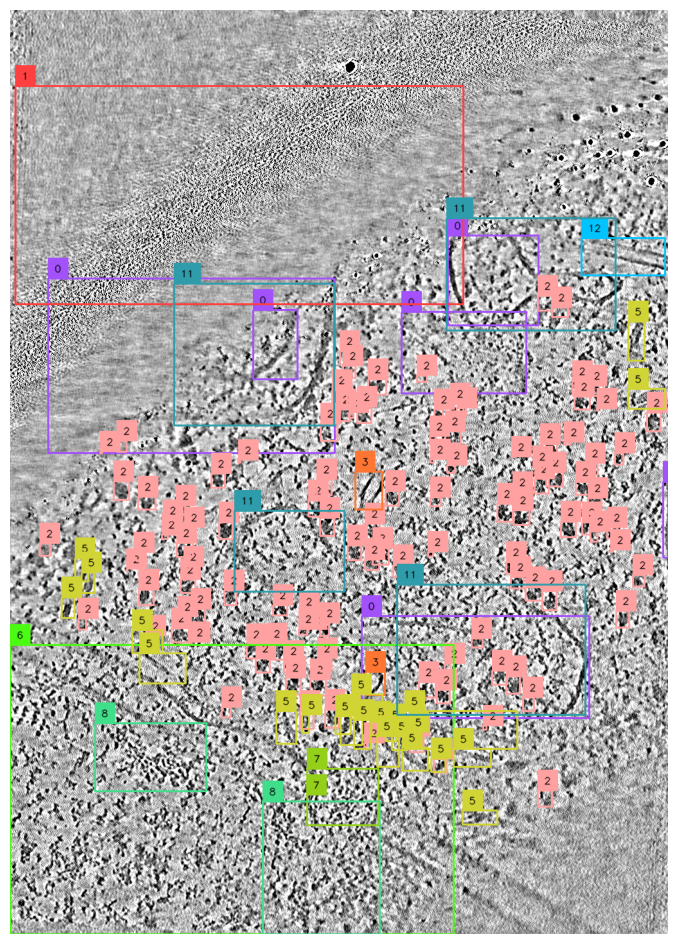

In [7]:
import random
# import cv2
import numpy as np


# select random image
image_ids = list(ds.images.keys())
image_id = random.choice(image_ids)
print('Image {}'.format(image_id))

# load image and annotatons 
image = ds.images["/data/tyfei/datasets/cyroem/test4/SingleChannelImage/TS_031_270.png"]
detections = ds.annotations["/data/tyfei/datasets/cyroem/test4/SingleChannelImage/TS_031_270.png"]
# image_path = os.path.join(ds.root, image['file_name'])
# image = mmcv.imread(image_path)

# annotate
# sv.Detections.from_coco_annotations(coco_annotation=annotations)
# we will use id2label function for training
# categories = ds.coco.cats
# id2label = {k: v['name'] for k,v in categories.items()}

# labels = [
#     f"{id2label[class_id]}" 
#     for _, _, class_id, _ 
#     in detections
# ]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections)
sv.plot_image(frame)

In [66]:
image_ids = list(ds.images.keys())

In [ ]:
import json
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)
with open("/data/tyfei/datasets/cyroem/test4/test_annotations.json", "w") as f:
    json.dump(ann, f, cls=NpEncoder)